# Bert 방식
- Bert 사전학습 모델 사용

In [16]:
# 필요한 라이브러리 임포트
import pandas as pd  # 데이터 처리를 위한 pandas
import numpy as np  # 수치 연산을 위한 numpy
import torch  # 딥러닝 프레임워크
from torch.utils.data import Dataset  # 커스텀 데이터셋 생성을 위한 클래스
from sklearn.model_selection import train_test_split  # 데이터 분할
from sklearn.metrics import accuracy_score  # 정확도 계산
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, TrainerCallback  # BERT 모델 관련
from datetime import datetime  # 시간 기록
import matplotlib.pyplot as plt  # 시각화
from transformers import EarlyStoppingCallback  # 조기 종료

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [18]:
import transformers, torch
transformers.__version__, torch.__version__

('4.52.4', '2.7.1+cu118')

# 기본값 설정

In [19]:
current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
current_time

'20250613_104129'

In [20]:
model_name = "bert-base-uncased"                                      # https://huggingface.co/google-bert/bert-base-uncased
submission_filename = f"submission_{model_name}_{current_time}.csv"   # 제출 파일 이름
submission_filename

'submission_bert-base-uncased_20250613_104129.csv'

# 데이터 불러오기

In [21]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# 커스텀 데이터셋 클래스 정의
- 하고자 하는 모델에 따라 변경 필요

In [ ]:
class DisasterDataset(Dataset):
    def __init__(self, texts, labels=None, tokernizer=None, max_length=128):
        self.encodings = tokernizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        # 각 데이터 포인트를 텐서로 변환
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Bert 토크나이저와 모델 초기화

In [23]:
tokernizer = AutoTokenizer.from_pretrained(model_name)            # 모델명 입력시 자동으로 토큰 가져옴
tokernizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [24]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2).to(device)
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# 데이터 분할

In [25]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'].tolist(),
    train_df['target'].tolist(),
    test_size=0.2,
    random_state=42
)
train_dataset = DisasterDataset(train_texts, train_labels, tokernizer)
val_dataset = DisasterDataset(val_texts, val_labels, tokernizer)

In [26]:
DisasterDataset.__len__(train_dataset)

6090

# 평가 지표 계산 함수 정의
(중요)

In [33]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'accuracy' : accuracy_score(p.label_ids, preds)}

In [28]:
# 학습 중 정확도 추적을 위한 콜백 클래스
class TrainMetricsCallback(TrainerCallback):
    def __init__(self):
        self.train_log = []  # 학습 로그 저장

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and 'loss' in logs and state.is_world_process_zero:
            # 현재 스텝의 학습 데이터에 대한 정확도 계산
            trainer.model.eval()
            with torch.no_grad():
                preds = []
                labels = []
                for batch in torch.utils.data.DataLoader(train_dataset, batch_size=64):
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    label = batch['labels'].to(device)
                    output = trainer.model(input_ids=input_ids, attention_mask=attention_mask)
                    pred = torch.argmax(output.logits, axis=1)
                    preds.extend(pred.cpu().numpy())
                    labels.extend(label.cpu().numpy())
            acc = accuracy_score(labels, preds)
            logs['train_accuracy'] = acc
            self.train_log.append({'step': state.global_step, 'train_accuracy': acc})
train_metrics_callback = TrainMetricsCallback()

# 학습 파라미터 설정
- 반드시 기억해야 할 것 중 한 옵션은 **조기 종료**
  + LightGBM, XGBoost, CatBoost에도 존재함
  + Pytorch 모델 만들 때도 필요
  + transformers 모델 만들 때도 필요

In [29]:
# TrainingArguments를 gpt한테 질문할 때, 반드시 버전을 명시해야 함.
# 파라미터 입력 오류 방지
training_args = TrainingArguments(
    output_dir='./results',  # 결과 저장 경로
    num_train_epochs=10,     # 최대 10 에포크
    load_best_model_at_end=True,  # 최고 성능 모델 저장
    metric_for_best_model="eval_accuracy",  # 조기 종료 기준
    greater_is_better=True,  # 높은 정확도가 좋음
    per_device_train_batch_size=16,  # 학습 배치 크기
    per_device_eval_batch_size=64,   # 평가 배치 크기
    warmup_steps=500,  # 워밍업 스텝
    weight_decay=0.01,  # 가중치 감쇠
    logging_dir='./logs',  # 로그 저장 경로
    logging_steps=50,  # 로깅 간격
    eval_strategy="steps",  # 평가 전략
    eval_steps=50,  # 평가 간격
    save_steps=500,  # 모델 저장 간격
    fp16=True,  # 16비트 정밀도 사용
    no_cuda=False,  # GPU 사용
    report_to="none",  # 외부 보고 비활성화
)

# 모델링

In [34]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    compute_metrics = compute_metrics,
    callbacks = [
        train_metrics_callback,
        EarlyStoppingCallback(early_stopping_patience=3)       # 3번 연속 성능 향상 없으면 중단 
    ]
)
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
50,0.603600,0.570207,0.764281
100,0.569600,0.525632,0.755745
150,0.473700,0.427722,0.818779
200,0.439400,0.432848,0.826658
250,0.422600,0.495062,0.787262
300,0.459100,0.386262,0.844386
350,0.421500,0.440042,0.817466
400,0.394600,0.422494,0.825345
450,0.355200,0.449590,0.838477


TrainOutput(global_step=450, training_loss=0.4599259779188368, metrics={'train_runtime': 104.0368, 'train_samples_per_second': 585.37, 'train_steps_per_second': 36.622, 'total_flos': 310540934198880.0, 'train_loss': 0.4599259779188368, 'epoch': 1.1811023622047245})

# 테스트 데이터 예측

In [36]:
test_texts = test_df['text'].tolist()
test_dataset = DisasterDataset(test_texts, tokernizer = tokernizer)
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis = 1)


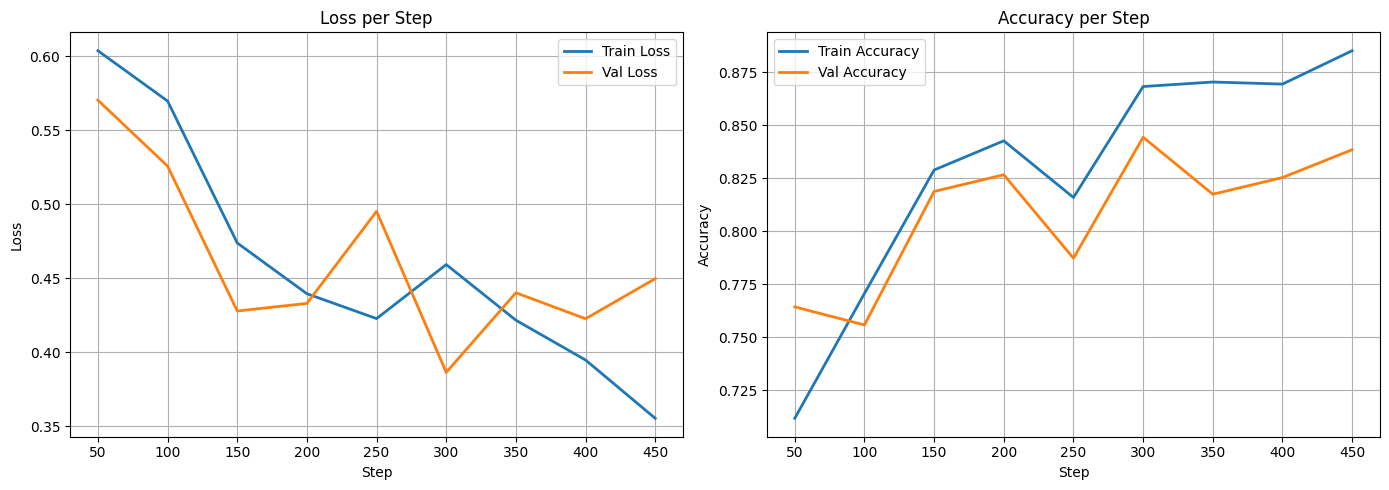

In [37]:
# 학습 로그 정리
log_df = pd.DataFrame(trainer.state.log_history)
train_acc_df = pd.DataFrame(train_metrics_callback.train_log)
log_df = log_df.merge(train_acc_df, on='step', how='left')

# 로그 파일 저장
log_df.to_csv(f'training_log_{model_name}_{current_time}.csv', index=False)

# 필요한 컬럼만 추출하여 정리
log_df_clean = log_df[['step', 'loss', 'eval_loss', 'eval_accuracy', 'train_accuracy']].copy()

# 컬럼명 일관성 있게 변경
log_df_clean.rename(columns={
    'loss': 'train_loss',
    'eval_loss': 'val_loss',
    'eval_accuracy': 'val_accuracy'
}, inplace=True)

# 스텝별 평균 계산 (중복 로그 처리)
summary_df = log_df_clean.groupby('step').mean().reset_index()

# 누락된 컬럼 NaN으로 채우기
for col in ['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy']:
    if col not in summary_df.columns:
        summary_df[col] = np.nan

# 학습 과정 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 손실 그래프
ax1.plot(summary_df['step'], summary_df['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(summary_df['step'], summary_df['val_loss'], label='Val Loss', linewidth=2)
ax1.set_title('Loss per Step')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

# 정확도 그래프
ax2.plot(summary_df['step'], summary_df['train_accuracy'], label='Train Accuracy', linewidth=2)
ax2.plot(summary_df['step'], summary_df['val_accuracy'], label='Val Accuracy', linewidth=2)
ax2.set_title('Accuracy per Step')
ax2.set_xlabel('Step')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()